In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import bioreactor as br
from bioreactor import (
    utils, cohort_data, qc, 
    cna, mutations, oncoplot2, annotation,
    plotting, use_colors, lollipop,
    gsea, ssgsea, graphs, pathway_scoring,
    survival
)

In [2]:
df = pd.read_excel('./Drokov_Tcells.xlsx')

In [3]:
path_to_uftp = '/uftp/users/ashchetsova/hackathon'

# Get GVHD status annotation

In [4]:
df_has_gvhd = df.groupby('ID')['cGVHD_development'].unique().apply(lambda x: False if x[0] == 'Без хрРТПХ' else True).rename('GVHD_status')

In [5]:
df_day_gvhd = df.groupby('ID')['cGVHD_development_time'].unique().apply(lambda x: x[0]).rename('GVHD_day')

In [6]:
df_gvhd = pd.concat([df_has_gvhd, df_day_gvhd], axis=1)
df_gvhd['GVHD_day'] = df_gvhd['GVHD_day'].fillna(0)
df_gvhd.loc[48]

GVHD_status    False
GVHD_day         0.0
Name: 48, dtype: object

In [7]:
df_gvhd.to_csv('/uftp/users/ashchetsova/hackathon/GVHD_status_annotation.tsv', sep='\t')

# ---

In [114]:
df['Days_agg'] = df['Days'].apply(lambda x: x.replace('+', '').replace(' день ', '').replace('хрРТПХ', '+'))

In [117]:
df['Days'].unique()

array(['+180', '+180 день хрРТПХ', '+30', '+30 день хрРТПХ', '+365',
       '+60', '+60 день хрРТПХ', '+90', '+90 день хрРТПХ', 'хрРТПХ'],
      dtype=object)

In [121]:
df['Days_agg'] = df['Days_agg'].apply(lambda x: x if x != '+' else '0+')

In [123]:
df['Days_agg'].unique()

array(['180', '180+', '30', '30+', '365', '60', '60+', '90', '90+', '0+'],
      dtype=object)

In [116]:
df

ID  Time_OS  cGVHD_development_time cGVHD_development  \
0      48      566                     NaN        Без хрРТПХ   
1      48      566                     NaN        Без хрРТПХ   
2      48      566                     NaN        Без хрРТПХ   
3      48      566                     NaN        Без хрРТПХ   
4      48      566                     NaN        Без хрРТПХ   
...    ..      ...                     ...               ...   
37879  32      256                    91.0       До +180 дня   
37880  32      256                    91.0       До +180 дня   
37881  32      256                    91.0       До +180 дня   
37882  32      256                    91.0       До +180 дня   
37883  32      256                    91.0       До +180 дня   

                                   Population info    Days    Abs_Value  \
0       CD8+ None (3) maturity and None expression    +180  1118.324359   
1           CD4+ None maturity and None expression    +180    51.219879   
2         Treg None maturity and TIGIT+ expression    +180    19.338749   
3             Treg TE maturity and None expression    +180     3.984792   
4          Treg None maturity and PD-1+ expression    +180    10.225548   
...                                            ...     ...          ...   
37879    CD8+ None(2) maturity and None expression  хрРТПХ   559.345480   
37880     CD8+ None maturity and TIGIT+ expression  хрРТПХ   475.926285   
37881       CD8+ TE maturity and TIGIT+ expression  хрРТПХ   419.475184   
37882  CD8+ TE maturity and PD-1-TIGIT+ expression  хрРТПХ    81.741070   
37883  CD8+ TE maturity and PD-1-TIGIT- expression  хрРТПХ    93.643753   

      Days_agg  new_id  
0          180  48_180  
1          180  48_180  
2          180  48_180  
3          180  48_180  
4          180  48_180  
...        ...     ...  
37879        +   32_91  
37880        +   32_91  
37881        +   32_91  
37882        +   32_91  
37883        +   32_91  

[37884 rows x 9 columns]

In [124]:
for i, row in df.iterrows():
    df.loc[i, 'new_id'] = f"{row['ID']}_{int(row['Days_agg'][:-1]) + int(df_gvhd.loc[row['ID'], 'GVHD_day']) if row['Days_agg'][-1] == '+' else int(row['Days_agg'])}"

In [134]:
df.drop(columns=['Days_agg']).to_csv(os.path.join(path_to_uftp, 'data_with_new_id.tsv'), sep='\t')

# get annotation for 90 day

In [8]:
df = pd.read_csv('/uftp/users/ashchetsova/hackathon/ID_vs_population_n_cells.tsv', sep='\t', index_col=0)
df['ID'] = df.index
df[['patient', 'day']] = df['ID'].str.split('_', expand=True)
df = df.astype({'patient': int, 'day': 'int'})
df['GVHD_status'] = df['patient'].apply(lambda x: df_gvhd.loc[x, 'GVHD_status'])
df['GVHD_day'] = df['patient'].apply(lambda x: df_gvhd.loc[x, 'GVHD_day'])
df

/tmp/ipykernel_81/2395625712.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['GVHD_status'] = df['patient'].apply(lambda x: df_gvhd.loc[x, 'GVHD_status'])
/tmp/ipykernel_81/2395625712.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['GVHD_day'] = df['patient'].apply(lambda x: df_gvhd.loc[x, 'GVHD_day'])


CD8+ None maturity and None expression  \
48_180                             1041.571832   
46_180                              958.390550   
52_180                             2078.558499   
60_180                              241.894059   
1_180                               256.213479   
...                                        ...   
49_186                              937.888445   
29_111                              829.942949   
8_203                               829.623915   
3_212                               136.089563   
32_91                               559.345480   

        CD4+ None maturity and None expression  \
48_180                               63.012814   
46_180                               61.078521   
52_180                               87.065141   
60_180                               65.946161   
1_180                               110.433402   
...                                        ...   
49_186                              126.321547   
29_111                               67.783024   
8_203                               188.961630   
3_212                               119.756002   
32_91                                57.411291   

        Treg None maturity and TIGIT+ expression  \
48_180                                 19.338749   
46_180                                 19.538432   
52_180                                 37.735327   
60_180                                  9.228302   
1_180                                  25.637034   
...                                          ...   
49_186                                 74.563779   
29_111                                 17.295425   
8_203                                  38.806315   
3_212                                  17.210634   
32_91                                  23.073199   

        Treg TE maturity and None expression  \
48_180                              3.984792   
46_180                              3.879472   
52_180                              5.601132   
60_180                              1.674668   
1_180                               4.438437   
...                                      ...   
49_186                              6.936536   
29_111                              5.185898   
8_203                               5.912073   
3_212                               2.752106   
32_91                               8.651384   

        Treg None maturity and PD-1+ expression  \
48_180                                10.225548   
46_180                                 7.140399   
52_180                                18.100685   
60_180                                 7.558041   
1_180                                 14.023321   
...                                         ...   
49_186                                44.744646   
29_111                                17.058875   
8_203                                 23.826099   
3_212                                  7.313309   
32_91                                 19.301536   

        Treg NV maturity and None expression  \
48_180                              5.481322   
46_180                              1.128574   
52_180                              1.428771   
60_180                              0.207130   
1_180                               1.297023   
...                                      ...   
49_186                              3.173266   
29_111                              0.518590   
8_203                               2.889359   
3_212                               1.264943   
32_91                               0.144900   

        Treg None maturity and HLA-DR+ expression  \
48_180                                  12.316223   
46_180                                  16.228672   
52_180                                  33.891671   
60_180                                   8.168414   
1_180                                   24.244816   
...                                           ...   
49_186                                  65.

In [9]:
df = df.drop(columns=['ID'])
df.to_csv('./ann.tsv', sep='\t')

In [399]:
df_90 = df[df['day'] == 90].copy()
df_90 = df_90.drop('11_90')
df_90[(df_90['GVHD_status']) & (df_90['GVHD_day'] < 90)]
df_90.to_csv('/uftp/users/ashchetsova/hackathon/data_90_day.tsv', sep='\t')

# 90 day

In [69]:
df = pd.read_csv('./ann.tsv', sep='\t', index_col=0)
# df = df.drop(columns=['Th22 EM maturity and None expression',
#  'Th17.1 NV maturity and None expression',
#  'Th22 CM maturity and None expression',
#  'Th17 TE maturity and None expression',
#  'Th1 EM maturity and None expression',
#  'Th17.1 CM maturity and None expression',
#  'CD8+ EMTM maturity and PD-1-TIGIT- expression',
#  'Th17.1 TE maturity and None expression',
#  'CD8+ EMTM maturity and PD-1-TIGIT+ expression',
#  'Treg_Th1 None maturity and None expression',
#  'CD8+ EMTM maturity and PD1+ expression',
#  'Treg_Th17.1 None maturity and None expression',
#  'Th17 EM maturity and None expression',
#  'CD8+ EM maturity and None expression',
#  'Treg None maturity and CD226+TIGIT- expression',
#  'Th22 TE maturity and None expression',
#  'Th17.1 EM maturity and None expression',
#  'CD8+ EMTM maturity and CD39+ expression',
#  'Th22 NV maturity and None expression',
#  'Th17 NV maturity and None expression',
#  'CD4+ EM maturity and None expression',
#  'CD8+ EMTM maturity and PD-1+TIGIT+ expression'])
# df = df.drop(columns=['Th2 TE maturity and None expression', 'Th2 EM maturity and None expression'])
# df = df.drop(index='26_90')
df.head()
# df.to_csv('./ann.tsv', sep='\t')

In [70]:
df_90 = df[df['day'] == 90].copy()
df_90 = df_90.drop('11_90')

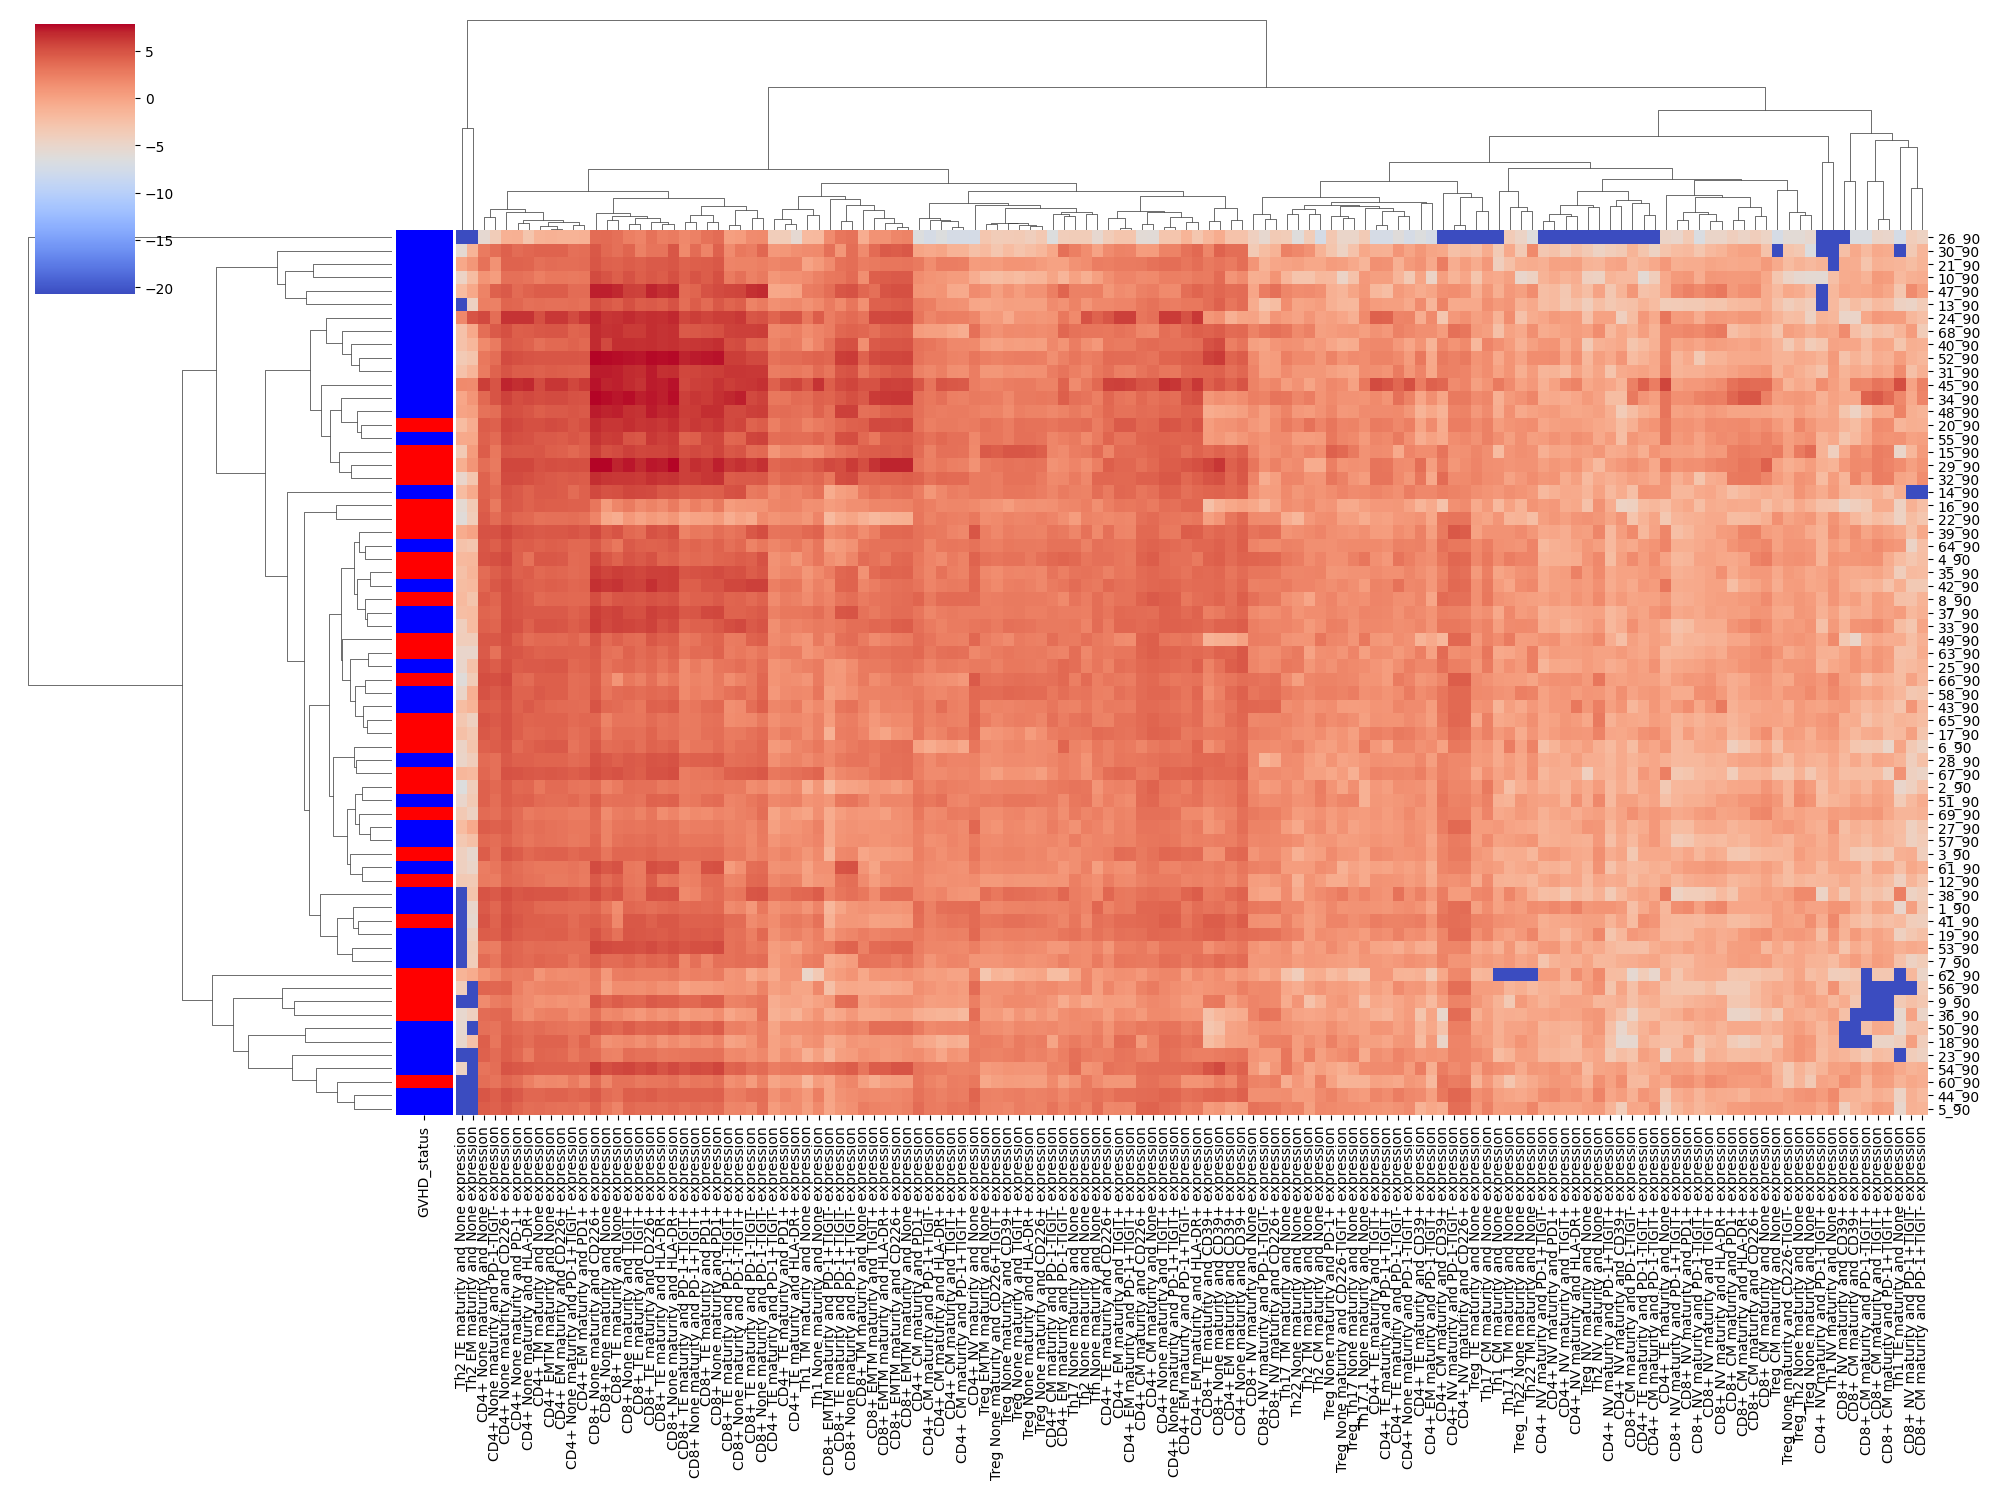

In [68]:
br.plotting.clustermap_wp(
    ds=np.log(df_90.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day']) + 0.000000001),
    figsize=(20,15), xl=True,
    cmap='coolwarm',
    row_colors=df_90['GVHD_status'].map(
        {False: 'blue', True: 'red'}
    )
)

In [15]:
df_90 = df_90.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day'])
median_deviation_90 = df_90.mad(axis=0) / (df_90.median(axis=0) + 1)

/tmp/ipykernel_81/3997875330.py:2: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  median_deviation_90 = df_90.mad(axis=0) / (df_90.median(axis=0) + 1)


In [536]:
md90_out = set(median_deviation_90[(median_deviation_90 < 0.5) | (median_deviation_90 > 4)].sort_values().index.values)

In [535]:
md180_out = set(median_deviation_180[(median_deviation_180 < 0.5) | (median_deviation_180 > 1.85)].sort_values().index.values)

In [538]:
remove = list(md90_out & md180_out)

In [539]:
median_deviation_90 = median_deviation_90[~median_deviation_90.index.isin(remove)]

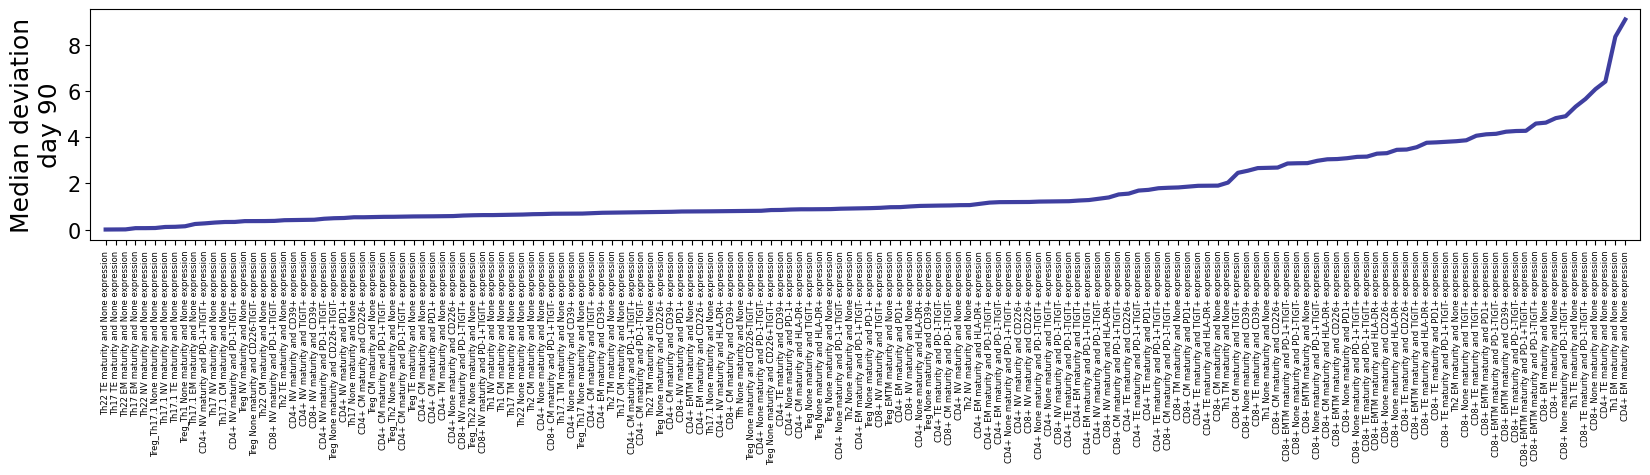

In [56]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(median_deviation_90.sort_values(), linewidth=3, color='#3f3fa0')
plt.margins(x=0.01)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=15)
plt.ylabel('Median deviation\nday 90', fontsize=18)
plt.show()

/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


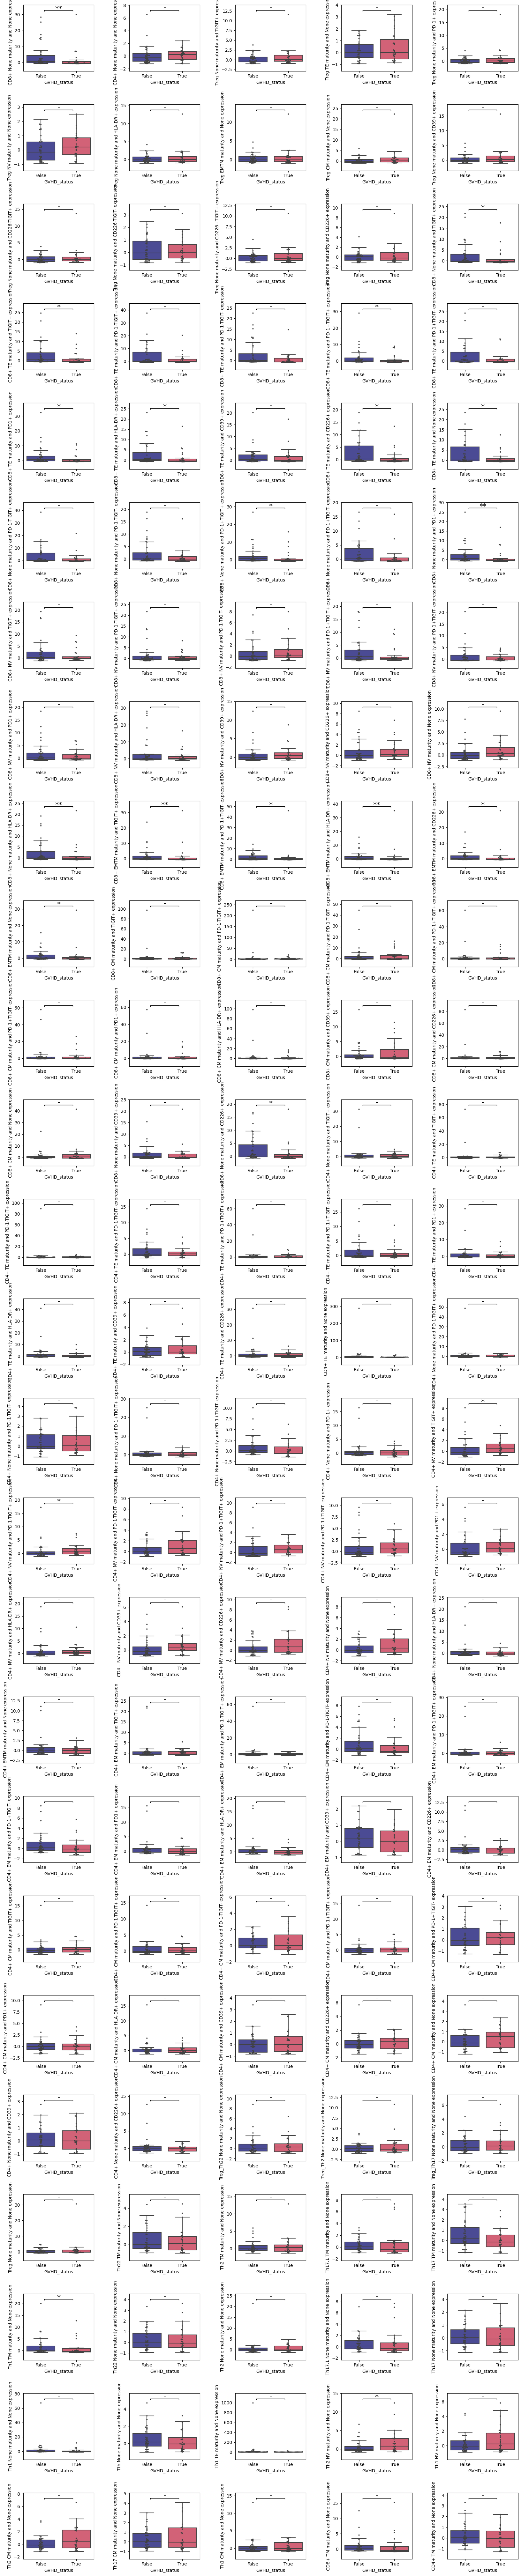

In [87]:
af = plotting.axis_net(5, 26)  #change size 
for name in df_90.columns[:-4]:
    ax=next(af)
    plotting.boxplot_with_pvalue(br.utils.median_scale(df_90[name]), df_90.GVHD_status,
                                 ax=ax, s=3, 
                                 palette={False: '#3f3fa0', True: '#e54f6b'})
    
plt.subplots_adjust(wspace=.5, hspace=.5)

# heatmap 180 day

In [62]:
df = pd.read_csv('./ann.tsv', sep='\t', index_col=0)
df.head()

CD8+ None maturity and None expression  \
48_180                             1041.571832   
46_180                              958.390550   
52_180                             2078.558499   
60_180                              241.894059   
1_180                               256.213479   

        CD4+ None maturity and None expression  \
48_180                               63.012814   
46_180                               61.078521   
52_180                               87.065141   
60_180                               65.946161   
1_180                               110.433402   

        Treg None maturity and TIGIT+ expression  \
48_180                                 19.338749   
46_180                                 19.538432   
52_180                                 37.735327   
60_180                                  9.228302   
1_180                                  25.637034   

        Treg TE maturity and None expression  \
48_180                              3.984792   
46_180                              3.879472   
52_180                              5.601132   
60_180                              1.674668   
1_180                               4.438437   

        Treg None maturity and PD-1+ expression  \
48_180                                10.225548   
46_180                                 7.140399   
52_180                                18.100685   
60_180                                 7.558041   
1_180                                 14.023321   

        Treg NV maturity and None expression  \
48_180                              5.481322   
46_180                              1.128574   
52_180                              1.428771   
60_180                              0.207130   
1_180                               1.297023   

        Treg None maturity and HLA-DR+ expression  \
48_180                                  12.316223   
46_180                                  16.228672   
52_180                                  33.891671   
60_180                                   8.168414   
1_180                                   24.244816   

        Treg EMTM maturity and None expression  \
48_180                               13.835090   
46_180                               14.199410   
52_180                               33.896054   
60_180                                7.346504   
1_180                                23.429714   

        Treg CM maturity and None expression  \
48_180                              1.371447   
46_180                              1.725416   
52_180                              2.454330   
60_180                              1.366177   
1_180                               0.725857   

        Treg None maturity and CD39+ expression  ...  \
48_180                                 5.936982  ...   
46_180                                18.713705  ...   
52_180                                30.161965  ...   
60_180                                10.244121  ...   
1_180                                 26.315294  ...   

        Th17 CM maturity and None expression  \
48_180                              3.818801   
46_180                              5.675663   
52_180                             20.378630   
60_180                              4.821291   
1_180                               2.587447   

        Th1 CM maturity and None expression  \
48_180                             0.723496   
46_180                             0.067914   
52_180                             0.163752   
60_180                             1.011061   
1_180                              0.245914   

        CD8+ TM maturity and None expression  \
48_180                             33.830493   
46_180                            302.072441   
52_180                            115.628646   
60_180                             42.285570   
1_180                              57.318849   

        CD8+ EM maturity and None expression  \
48_180                             65.616696   
46_18

In [63]:
df_180 = df[df['day'] == 180].copy()
for i, row in df_180.iterrows():
    if row['GVHD_status']:
        if row['day'] < row['GVHD_day']:
            df_180.loc[i, 'GVHD_status_180'] = 'pre-GVHD'
        else:
            df_180.loc[i, 'GVHD_status_180'] = 'GVHD'
    else:
        df_180.loc[i, 'GVHD_status_180'] = 'no'

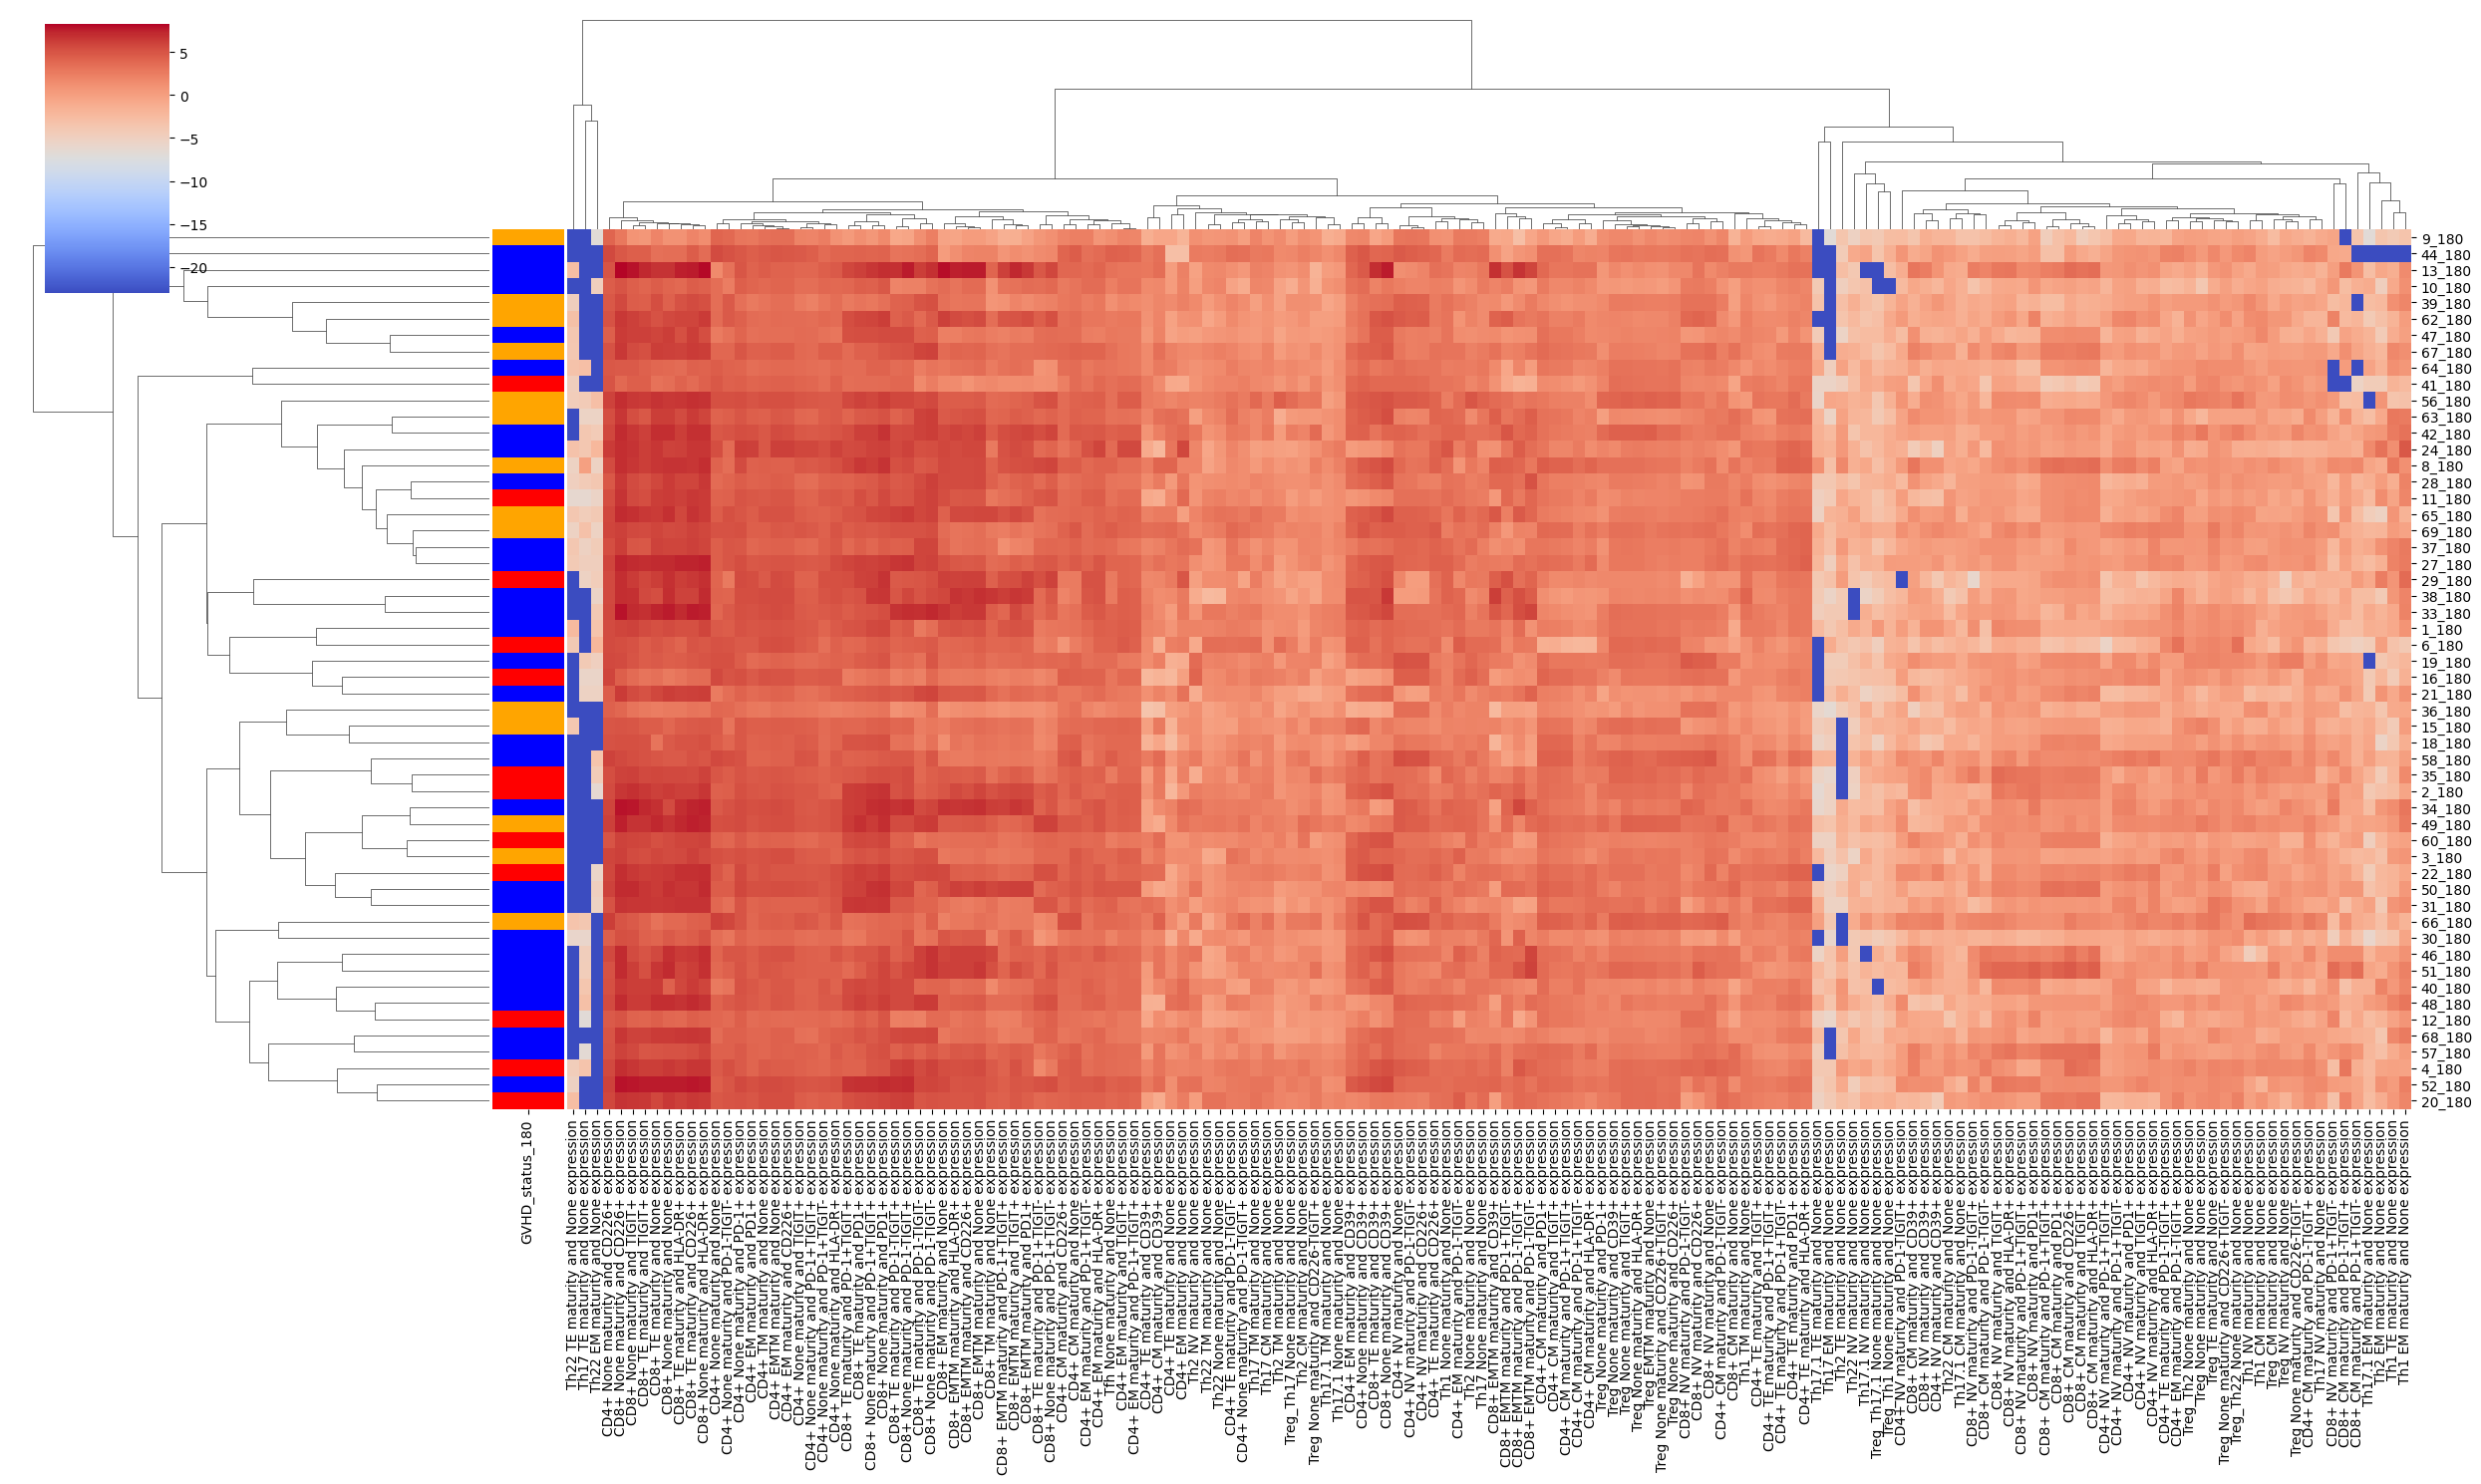

In [64]:
br.plotting.clustermap_wp(
    ds=np.log(df_180.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day', 'GVHD_status_180']) + 0.0000000001), 
    figsize=(25,15), xl=True,
    cmap='coolwarm',
    row_colors=df_180['GVHD_status_180'].map(
        {'no': 'blue', 'pre-GVHD': 'orange', 'GVHD': 'red'}
    )
)

<Axes: >

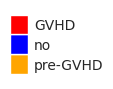

In [331]:
br.plotting.patch_plot({'no': 'blue', 'pre-GVHD': 'orange', 'GVHD': 'red'})

/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/se

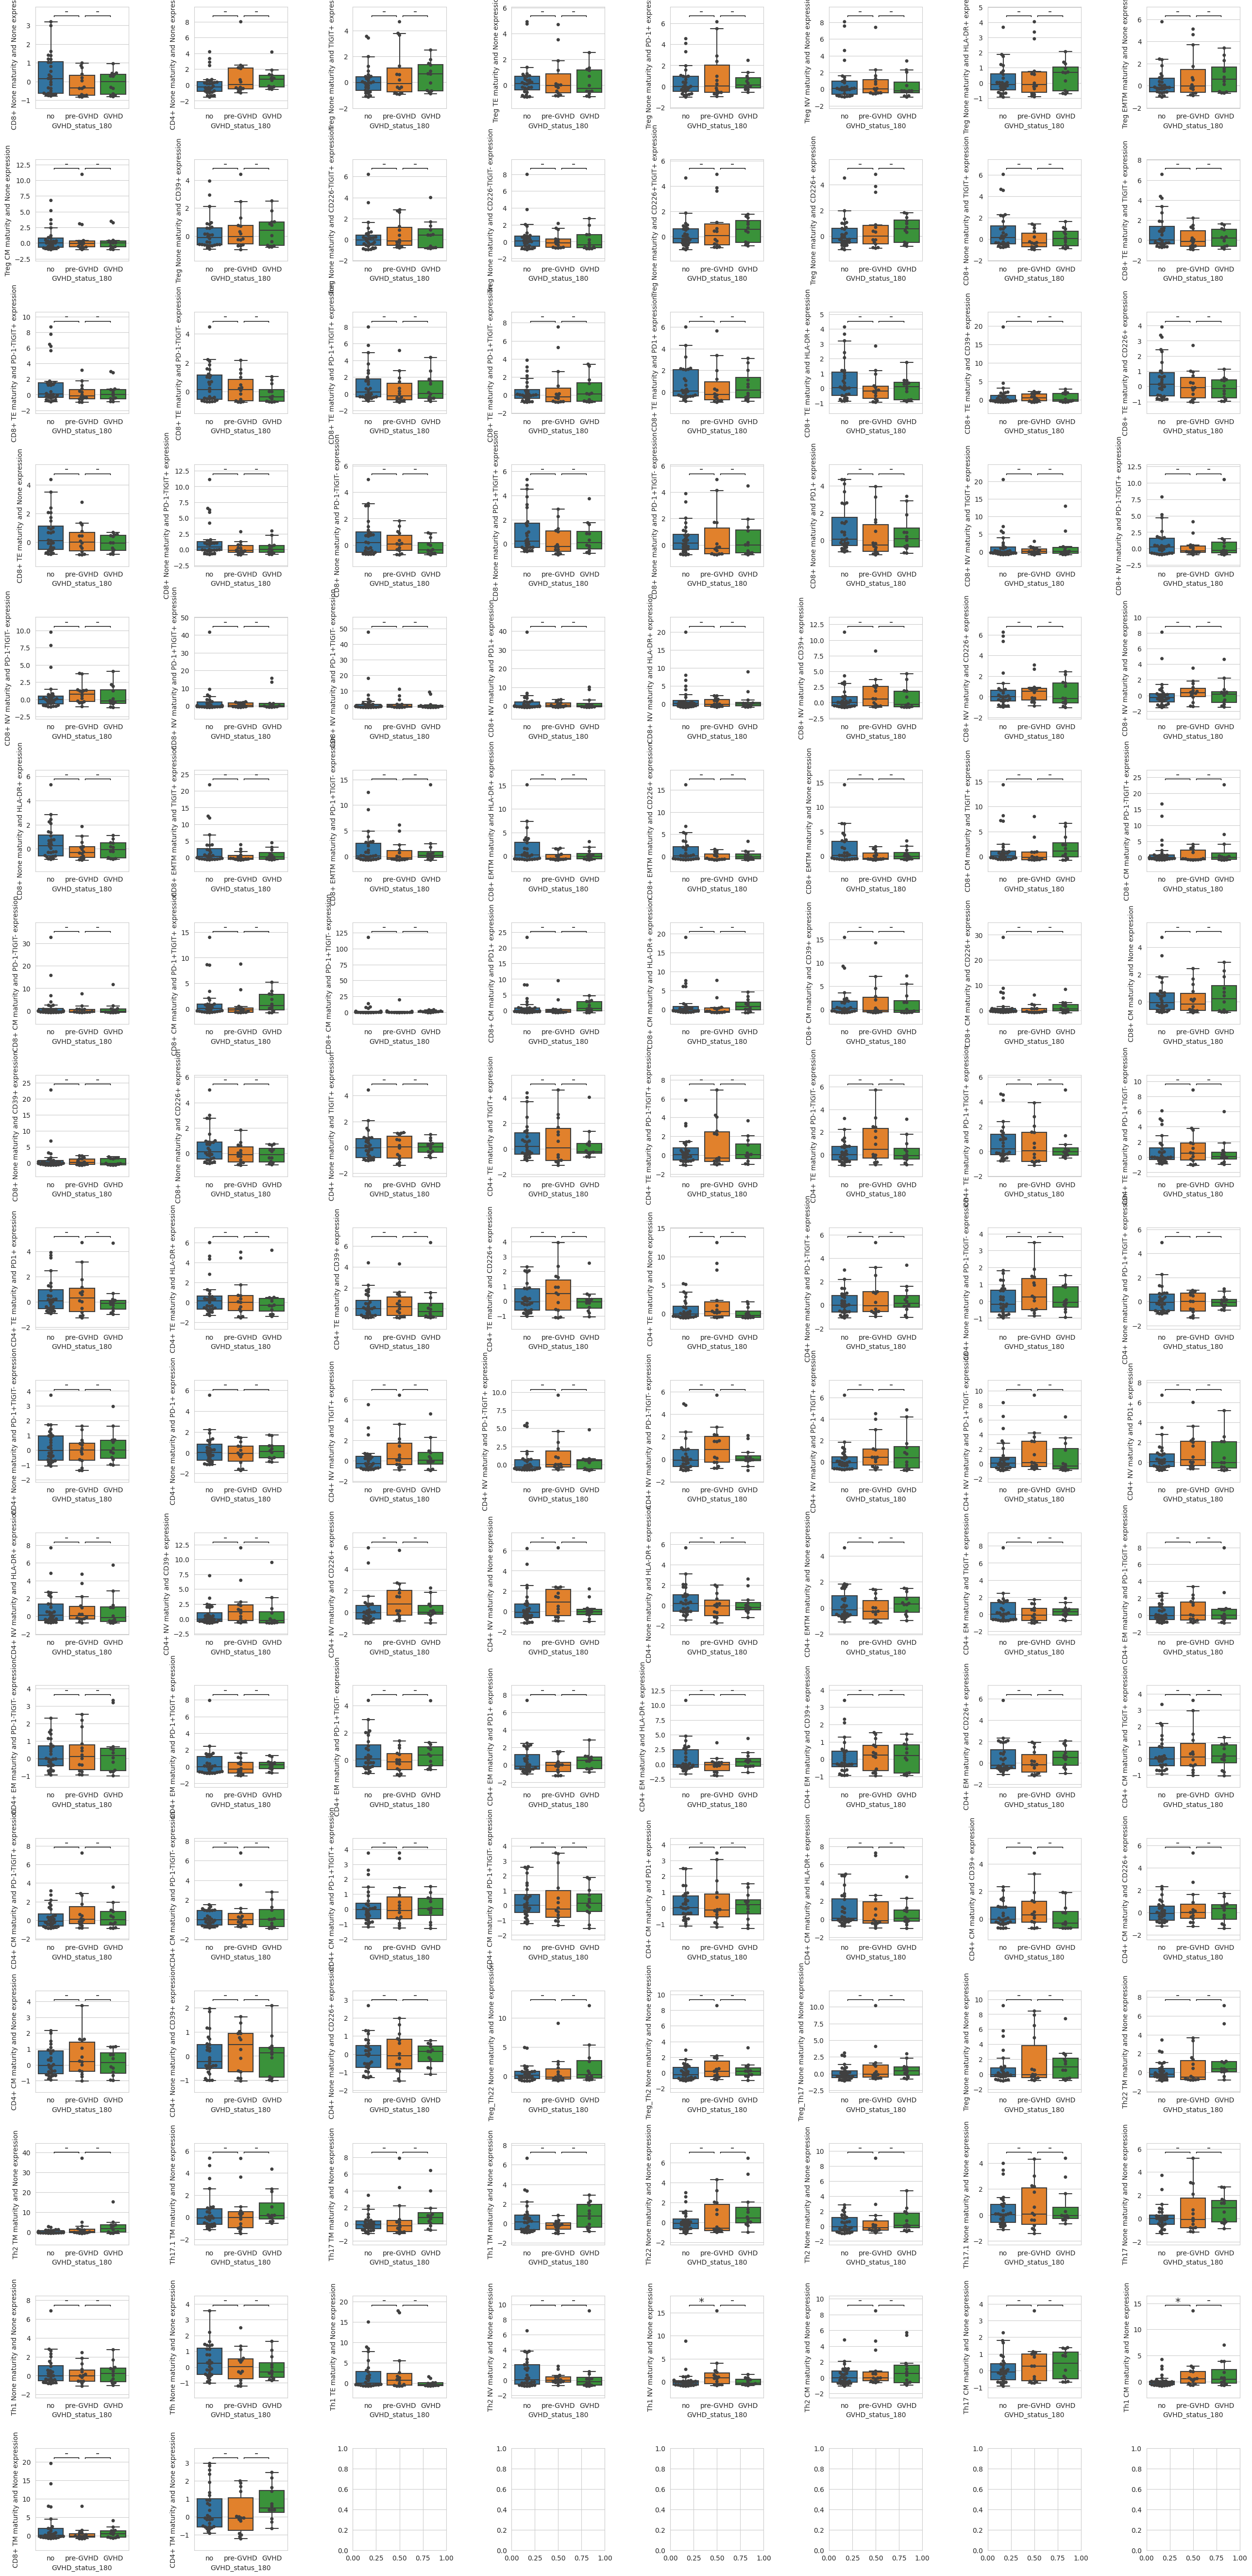

In [51]:
# df_180 = df_180[(df_180['GVHD_status_180'] == 'GVHD') | (df_180['GVHD_status_180'] == 'no')]
af = plotting.axis_net(8, 17)  #change size 
for name in df_180.columns[:-5]:
    plotting.boxplot_with_pvalue(br.utils.median_scale(df_180[name]), df_180.GVHD_status_180, order=['no', 'pre-GVHD', 'GVHD'],
                                 ax=next(af),s=5)
    
plt.subplots_adjust(wspace=.7, hspace=.5)

In [53]:
df_180 = df_180.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day', 'GVHD_status_180'])
median_deviation_180 = df_180.mad(axis=0) / (df_180.median(axis=0) + 1)

/tmp/ipykernel_81/522067240.py:2: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  median_deviation_180 = df_180.mad(axis=0) / (df_180.median(axis=0) + 1)


In [541]:
median_deviation_180 = median_deviation_180[~median_deviation_180.index.isin(remove)]

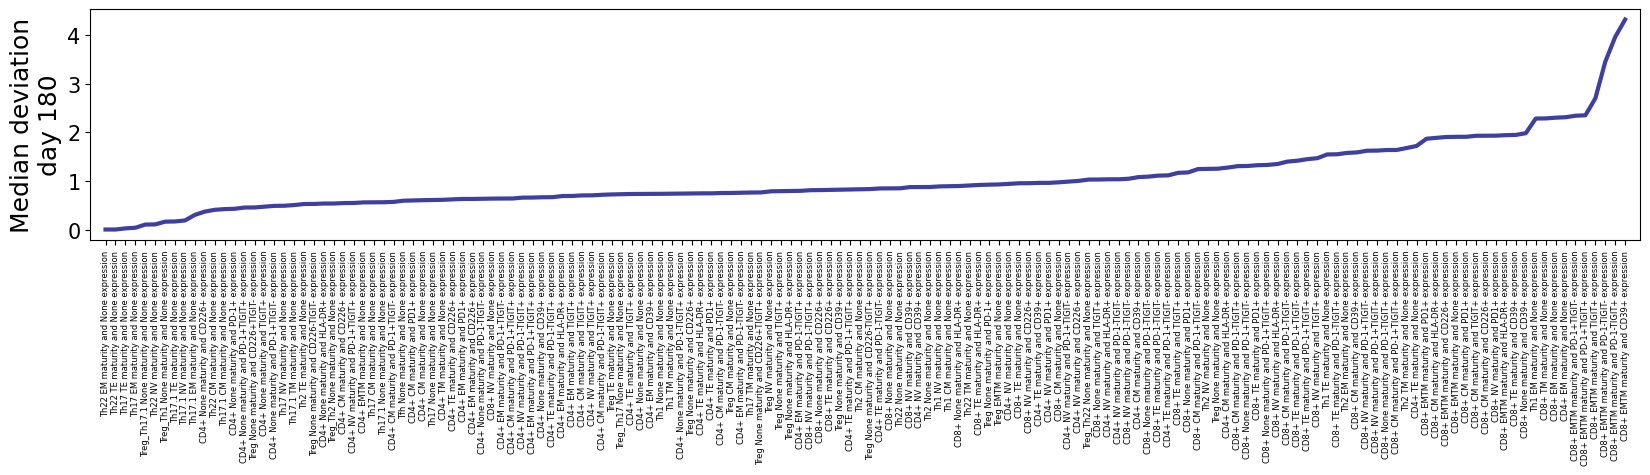

In [57]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(median_deviation_180.sort_values(), linewidth=3, color='#3f3fa0')
plt.margins(x=0.01)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=15)
plt.ylabel('Median deviation\nday 180', fontsize=18)
plt.show()

# heatmap gvhd+

In [58]:
df = pd.read_csv('./ann.tsv', sep='\t', index_col=0)

In [59]:
df_gvhd = df[df['GVHD_status']].copy()
df_gvhd['GVHD_status'] = df_gvhd.apply(lambda row: 'pre-GVHD' if row['day'] < row['GVHD_day'] else 'GVHD', axis=1)
df_gvhd['GVHD+_day'] = df_gvhd['day'] - df_gvhd['GVHD_day']
df_gvhd

CD8+ None maturity and None expression  \
60_180                              241.894059   
16_180                               14.730975   
15_180                               52.379617   
62_180                              277.175851   
65_180                              942.855881   
...                                        ...   
49_186                              937.888445   
29_111                              829.942949   
8_203                               829.623915   
3_212                               136.089563   
32_91                               559.345480   

        CD4+ None maturity and None expression  \
60_180                               65.946161   
16_180                              280.785025   
15_180                              111.230840   
62_180                               37.260804   
65_180                               98.054089   
...                                        ...   
49_186                              126.321547   
29_111                               67.783024   
8_203                               188.961630   
3_212                               119.756002   
32_91                                57.411291   

        Treg None maturity and TIGIT+ expression  \
60_180                                  9.228302   
16_180                                 18.110652   
15_180                                 38.023549   
62_180                                  6.665991   
65_180                                 13.139330   
...                                          ...   
49_186                                 74.563779   
29_111                                 17.295425   
8_203                                  38.806315   
3_212                                  17.210634   
32_91                                  23.073199   

        Treg TE maturity and None expression  \
60_180                              1.674668   
16_180                              1.115162   
15_180                              3.306744   
62_180                              1.291439   
65_180                              3.290553   
...                                      ...   
49_186                              6.936536   
29_111                              5.185898   
8_203                               5.912073   
3_212                               2.752106   
32_91                               8.651384   

        Treg None maturity and PD-1+ expression  \
60_180                                 7.558041   
16_180                                 9.543209   
15_180                                23.632942   
62_180                                 6.325731   
65_180                                 2.599491   
...                                         ...   
49_186                                44.744646   
29_111                                17.058875   
8_203                                 23.826099   
3_212                                  7.313309   
32_91                                 19.301536   

        Treg NV maturity and None expression  \
60_180                              0.207130   
16_180                              0.825648   
15_180                              0.496412   
62_180                              1.948758   
65_180                              0.617837   
...                                      ...   
49_186                              3.173266   
29_111                              0.518590   
8_203                               2.889359   
3_212                               1.264943   
32_91                               0.144900   

        Treg None maturity and HLA-DR+ expression  \
60_180                                   8.168414   
16_180                                  17.746080   
15_180                                  24.137361   
62_180                                   5.173489   
65_180                                  13.002033   
...                                           ...   
49_186                                  65.

<Axes: >

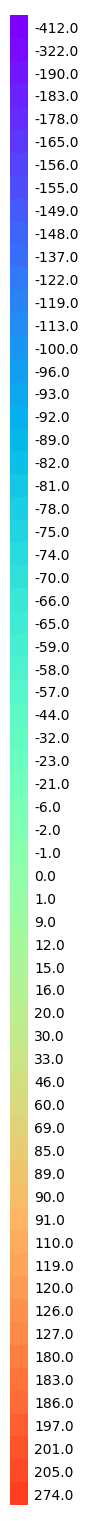

In [60]:
br.plotting.patch_plot(br.plotting.lin_colors(df_gvhd['GVHD+_day']))

/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


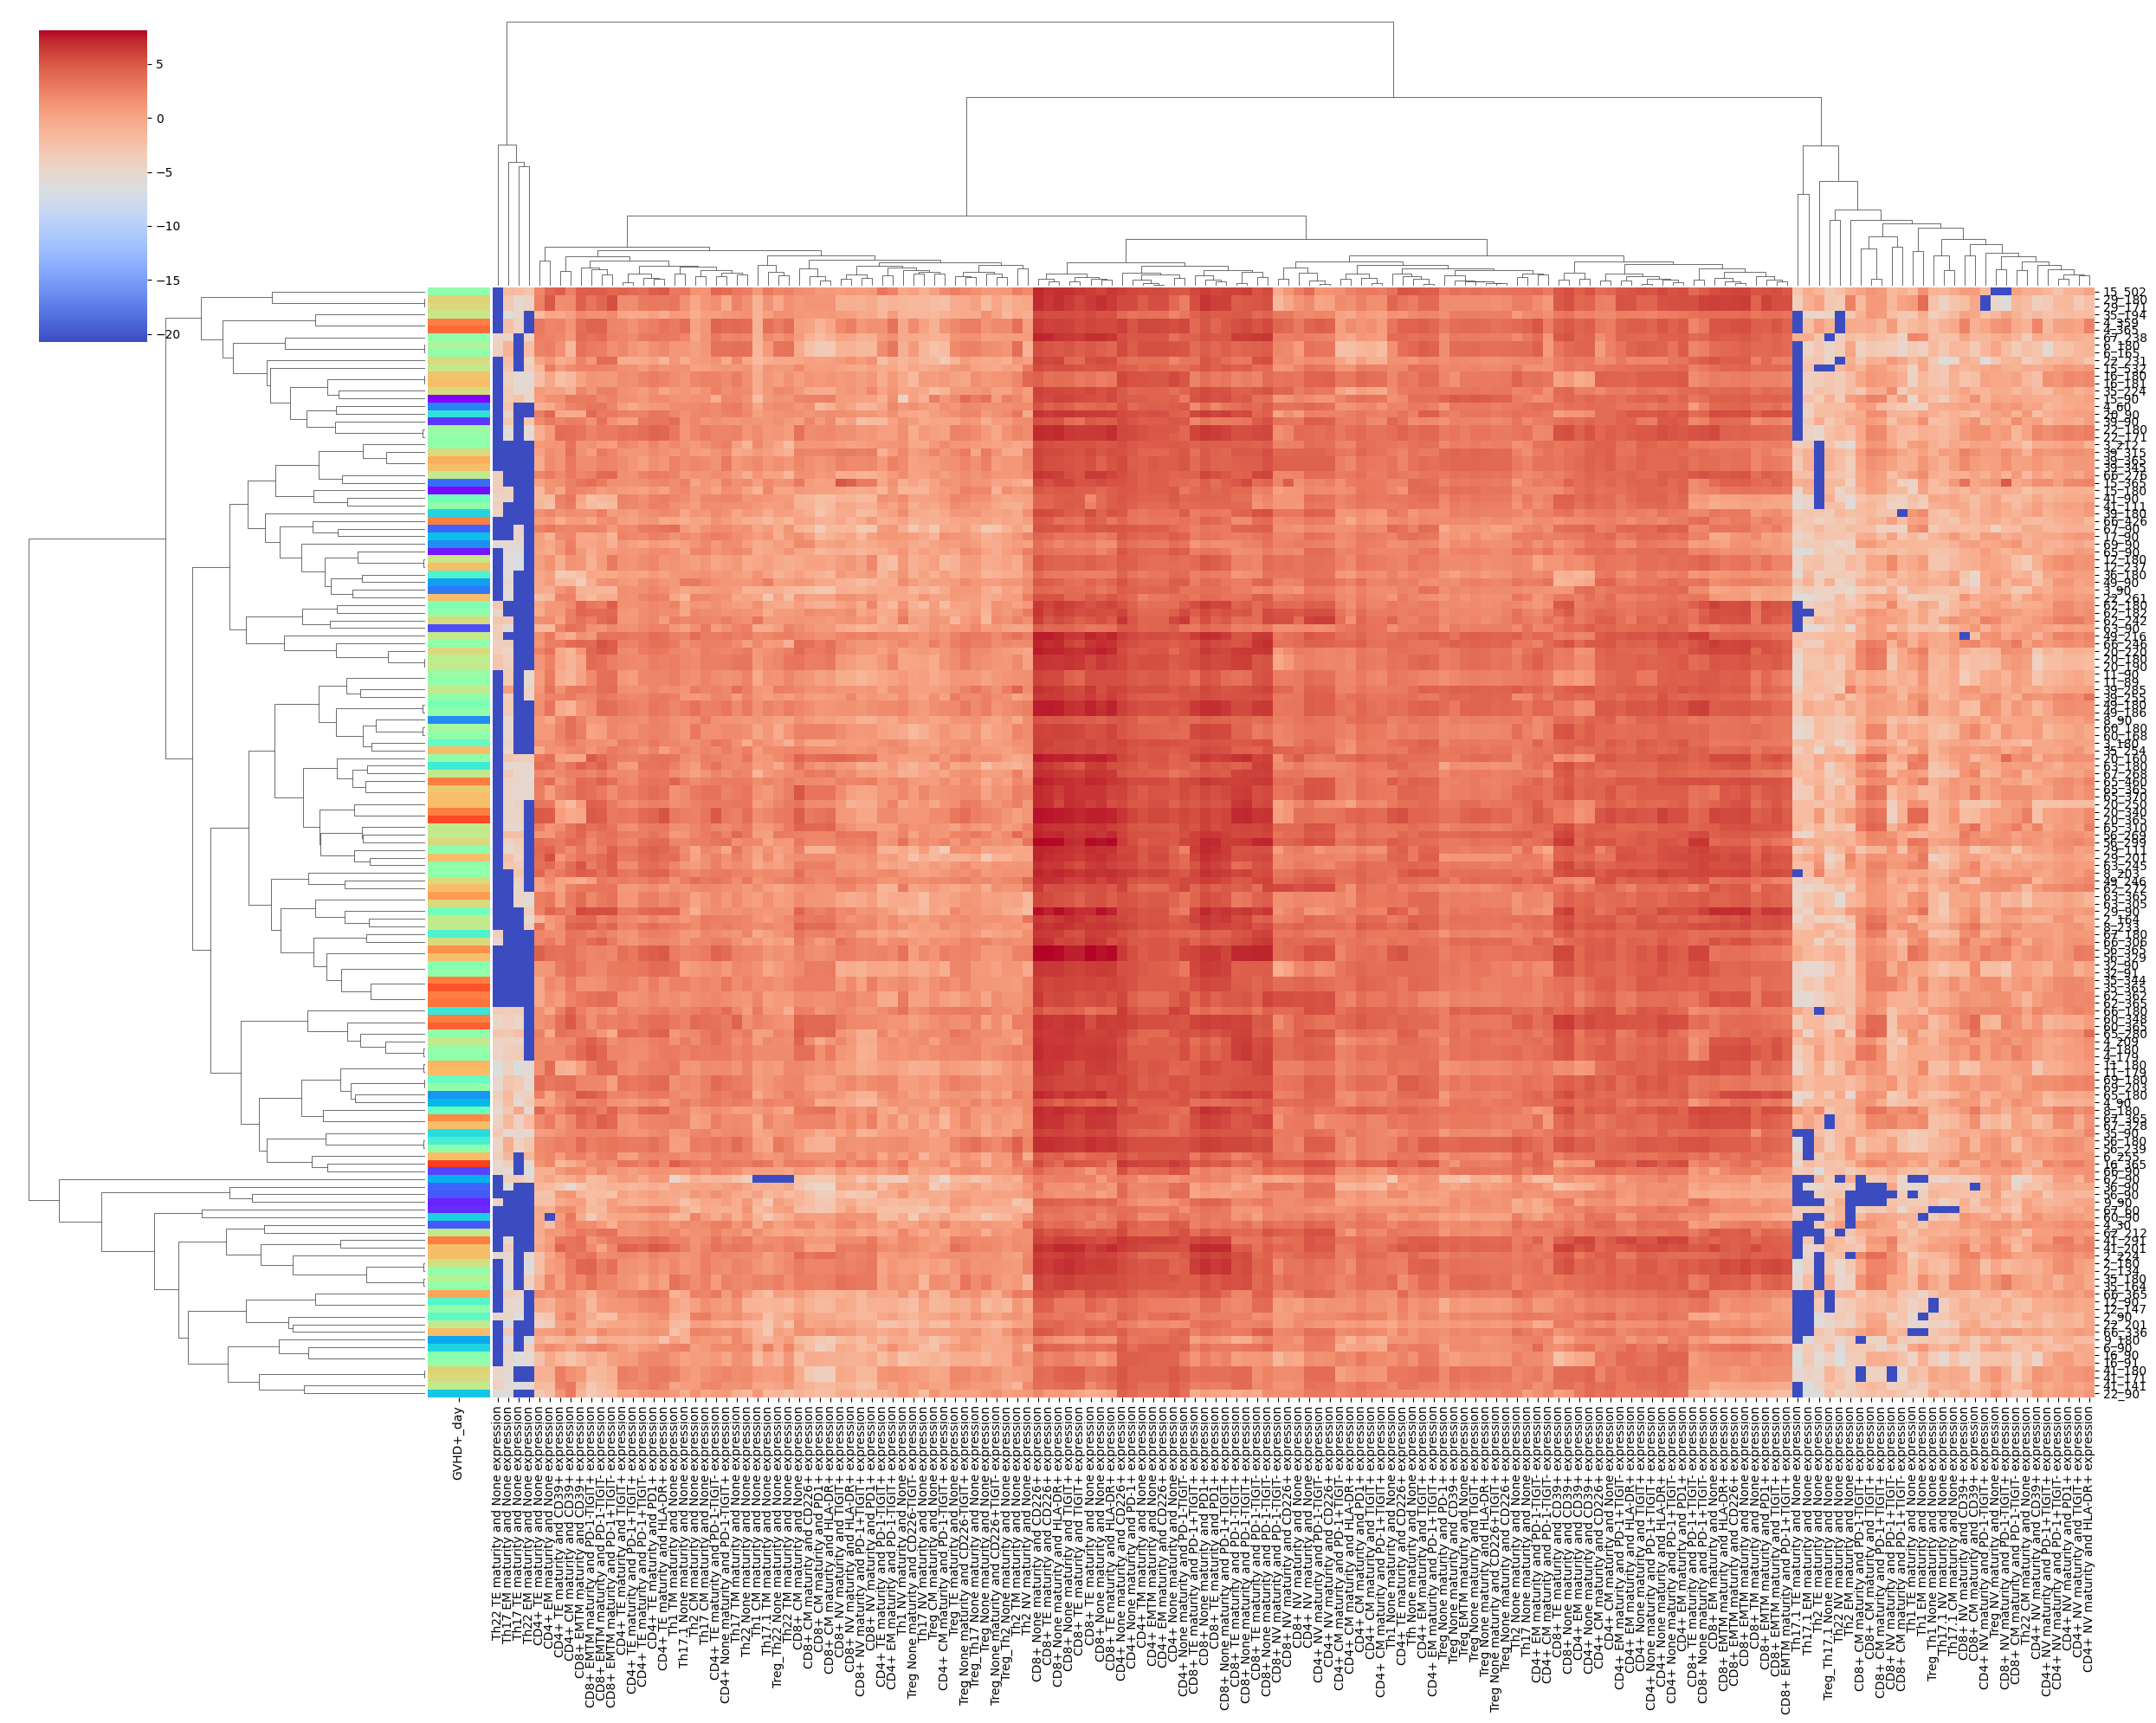

In [61]:
br.plotting.clustermap_wp(
    ds=np.log(df_gvhd.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day', 'GVHD+_day']) + 0.000000001), 
    figsize=(25,20), xl=True,
    cmap='coolwarm',
    row_colors=df_gvhd['GVHD+_day'].map(
        br.plotting.lin_colors(df_gvhd['GVHD+_day'])
    )
)

In [478]:
df_gvhd = df_gvhd.loc[:,~df_gvhd.columns.str.startswith('T')]

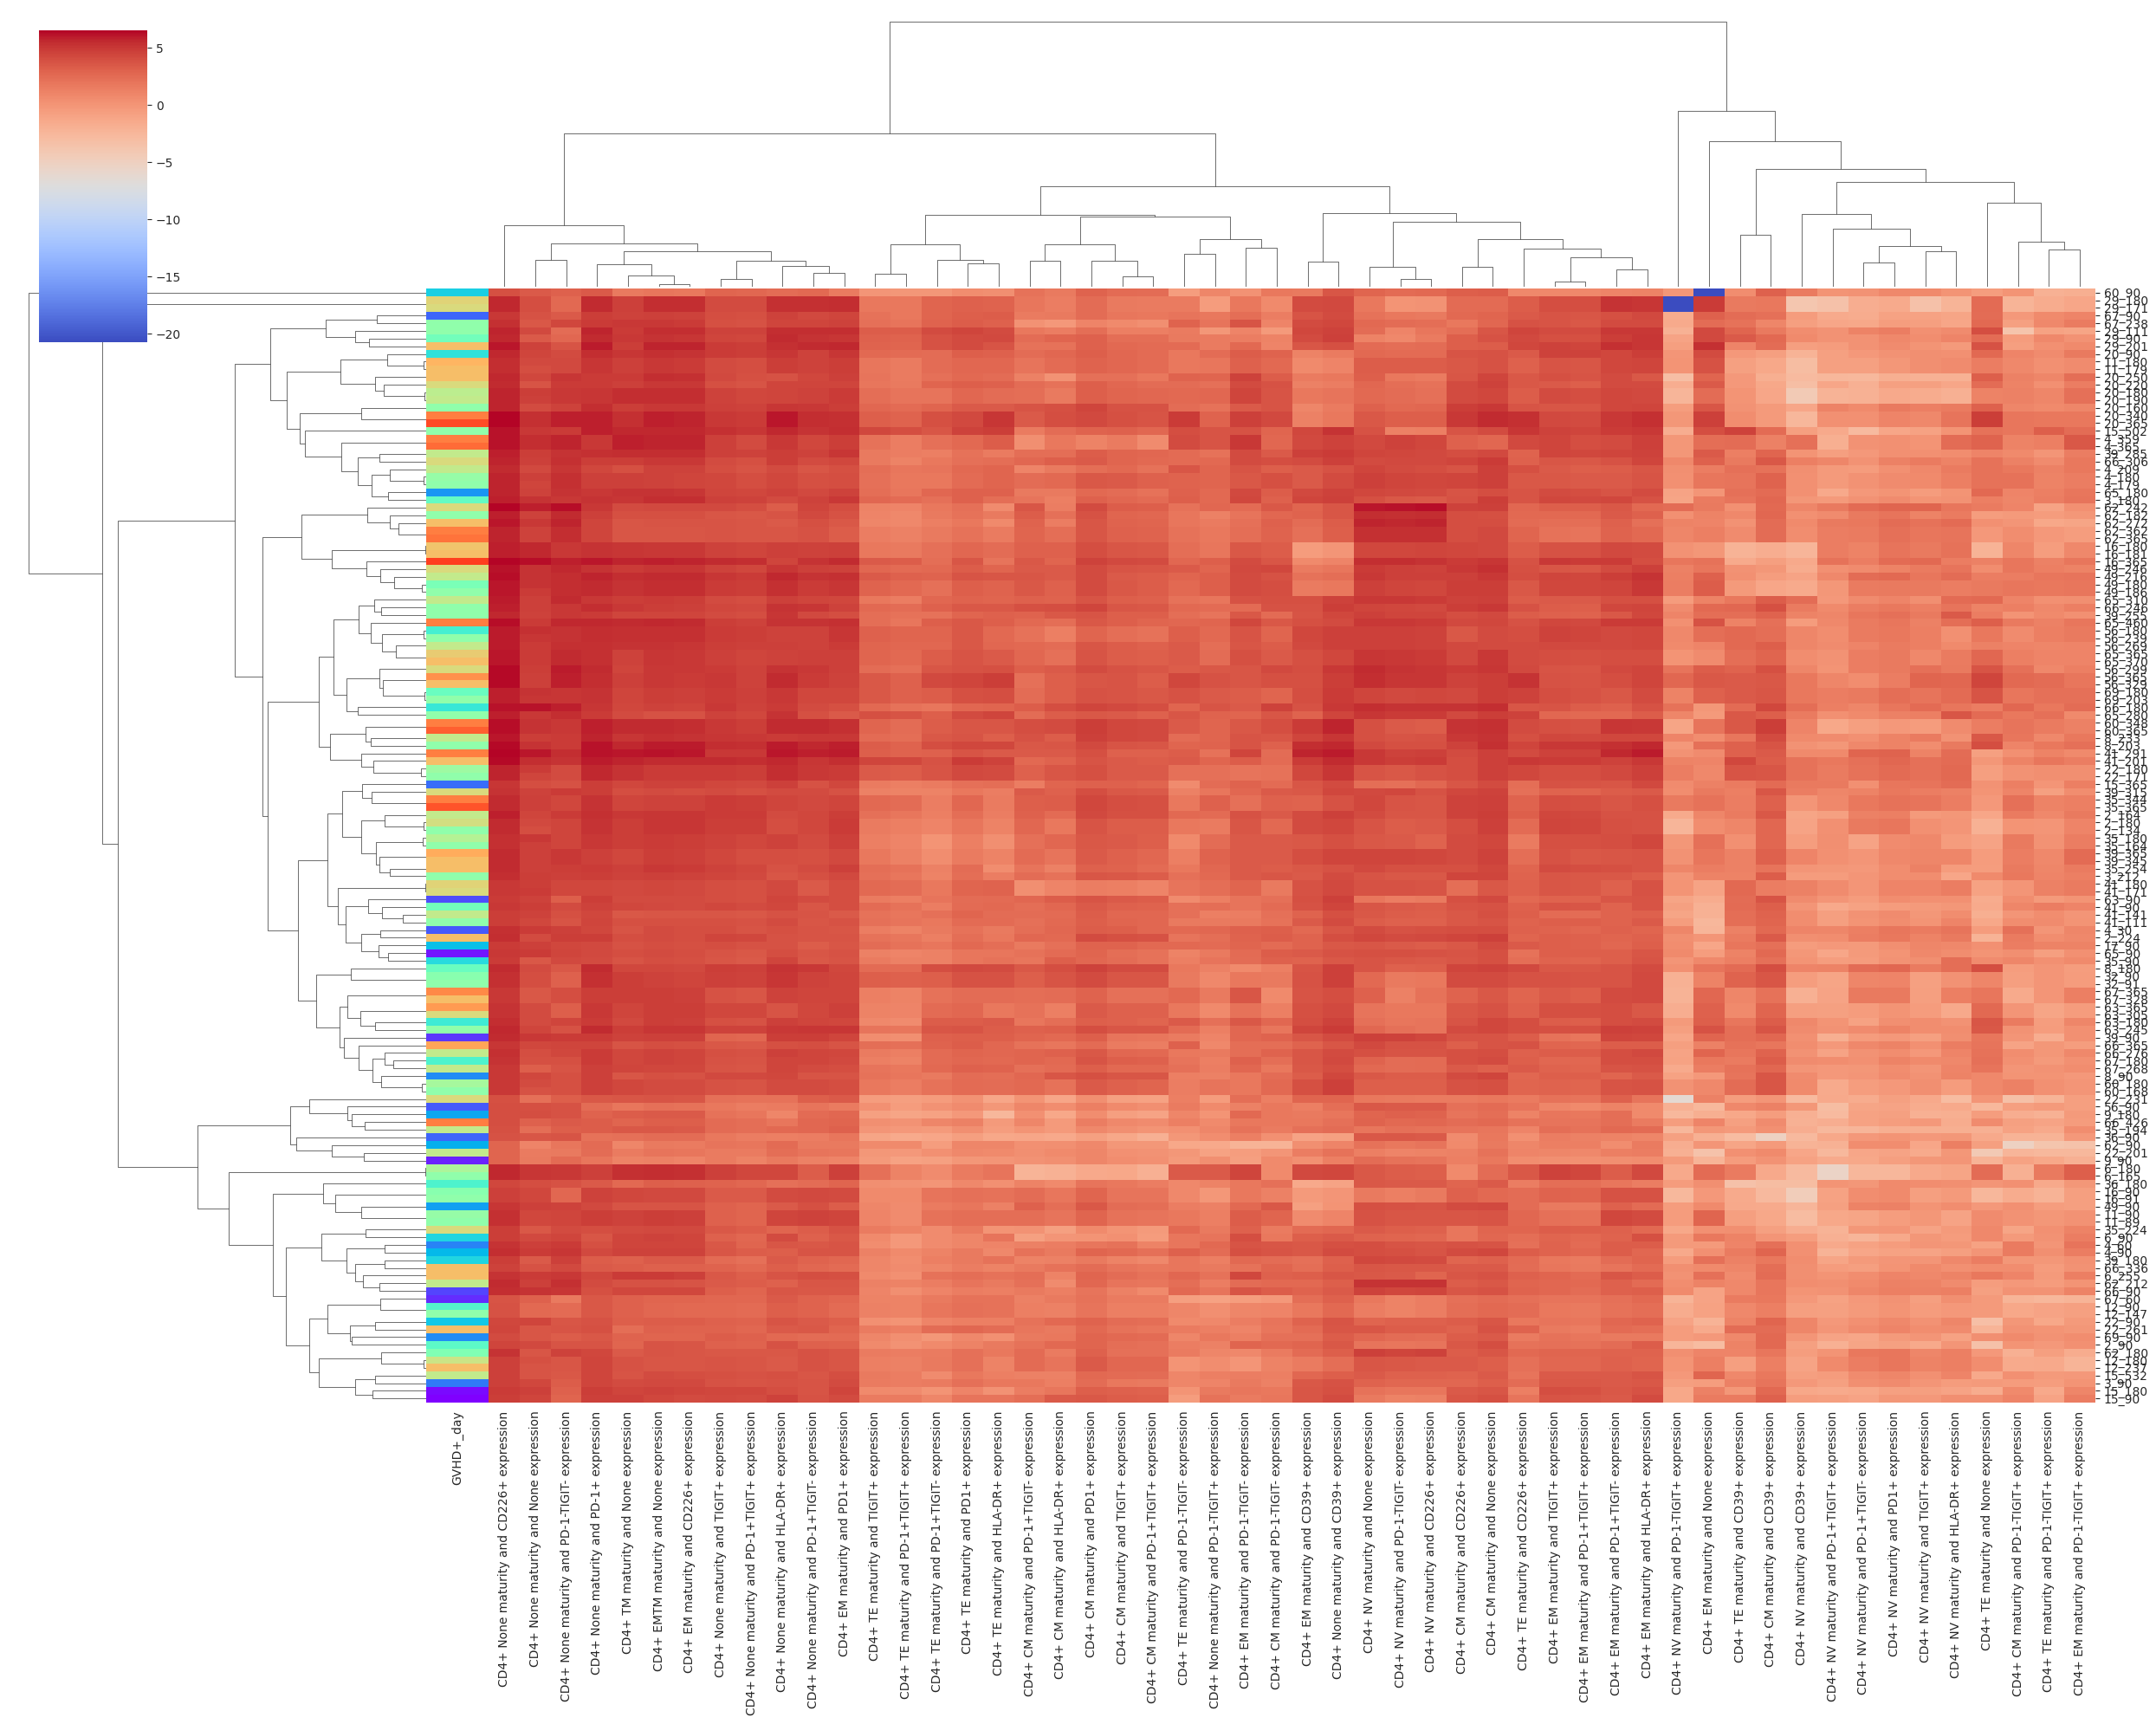

In [479]:
br.plotting.clustermap_wp(
    ds=np.log(df_gvhd.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day', 'GVHD+_day']) + 0.000000001), 
    figsize=(25,20), xl=True,
    cmap='coolwarm',
    row_colors=df_gvhd['GVHD+_day'].map(
        br.plotting.lin_colors(df_gvhd['GVHD+_day'])
    )
)

# heatmap gvhd-

In [47]:
df_wo_gvhd = df[~df['GVHD_status']].copy()
df_wo_gvhd

CD8+ None maturity and None expression  \
48_180                             1041.571832   
46_180                              958.390550   
52_180                             2078.558499   
1_180                               256.213479   
50_180                              962.344104   
...                                        ...   
18_90                                 3.324198   
45_90                              1107.697863   
5_90                                 17.940814   
23_90                                 9.955613   
55_90                               410.365066   

        CD4+ None maturity and None expression  \
48_180                               63.012814   
46_180                               61.078521   
52_180                               87.065141   
1_180                               110.433402   
50_180                               94.496810   
...                                        ...   
18_90                                73.834092   
45_90                               397.773416   
5_90                                 81.948073   
23_90                                65.157043   
55_90                                66.188750   

        Treg None maturity and TIGIT+ expression  \
48_180                                 19.338749   
46_180                                 19.538432   
52_180                                 37.735327   
1_180                                  25.637034   
50_180                                 18.423914   
...                                          ...   
18_90                                  14.379272   
45_90                                  13.449777   
5_90                                   11.982194   
23_90                                  14.206579   
55_90                                  27.726062   

        Treg TE maturity and None expression  \
48_180                              3.984792   
46_180                              3.879472   
52_180                              5.601132   
1_180                               4.438437   
50_180                              3.592172   
...                                      ...   
18_90                               2.388789   
45_90                               1.171121   
5_90                                2.060163   
23_90                               5.224222   
55_90                               3.270320   

        Treg None maturity and PD-1+ expression  \
48_180                                10.225548   
46_180                                 7.140399   
52_180                                18.100685   
1_180                                 14.023321   
50_180                                13.653061   
...                                         ...   
18_90                                  9.485356   
45_90                                  6.109145   
5_90                                   5.946133   
23_90                                  3.031976   
55_90                                 18.351578   

        Treg NV maturity and None expression  \
48_180                              5.481322   
46_180                              1.128574   
52_180                              1.428771   
1_180                               1.297023   
50_180                              2.939688   
...                                      ...   
18_90                               1.469726   
45_90                               0.712331   
5_90                                1.479721   
23_90                               0.492137   
55_90                               3.029281   

        Treg None maturity and HLA-DR+ expression  \
48_180                                  12.316223   
46_180                                  16.228672   
52_180                                  33.891671   
1_180                                   24.244816   
50_180                                  16.220903   
...                                           ...   
18_90                                   10.

/home/jovyan/venvs/bior_39/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


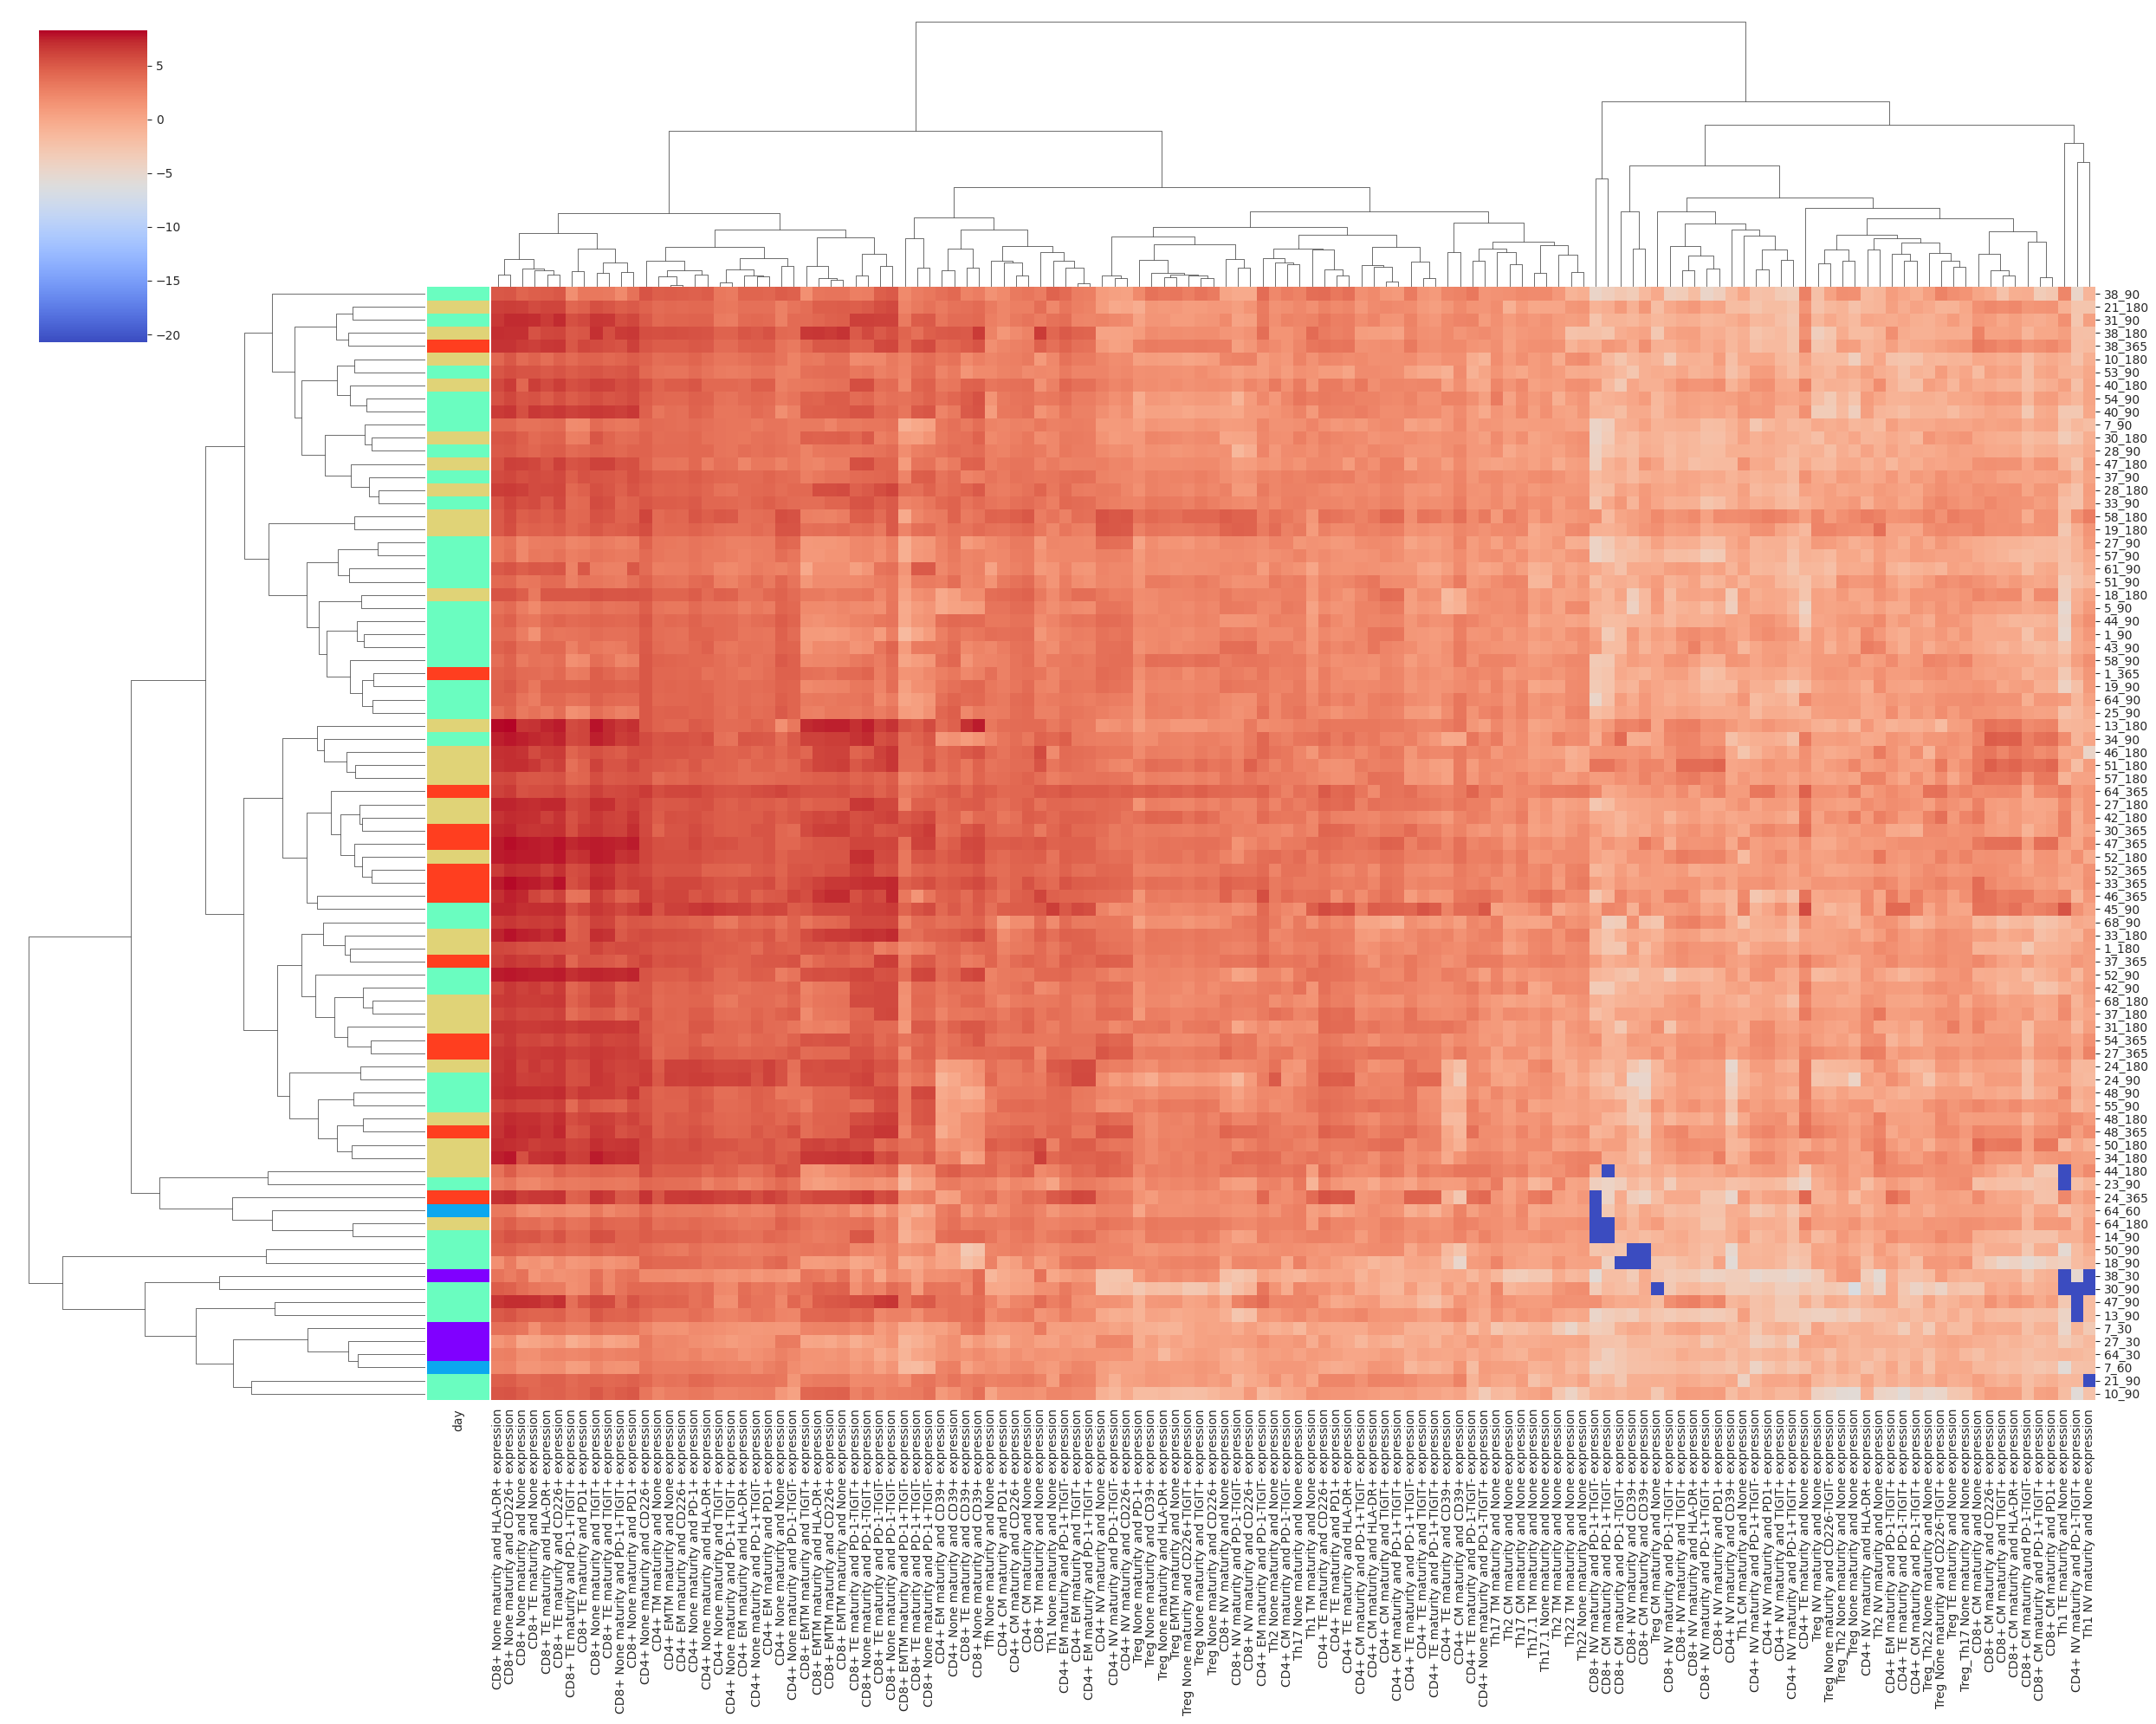

In [48]:
br.plotting.clustermap_wp(
    ds=np.log(df_wo_gvhd.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day']) + 0.000000001), 
    figsize=(25,20), xl=True,
    cmap='coolwarm',
    row_colors=df_wo_gvhd['day'].map(
        br.plotting.lin_colors(df_wo_gvhd['day'])
    )
)

<Axes: >

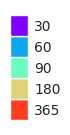

In [487]:
br.plotting.patch_plot(br.plotting.lin_colors(df_wo_gvhd['day']))

In [49]:
df_wo_gvhd = df_wo_gvhd.loc[:,~df_wo_gvhd.columns.str.startswith('T')]

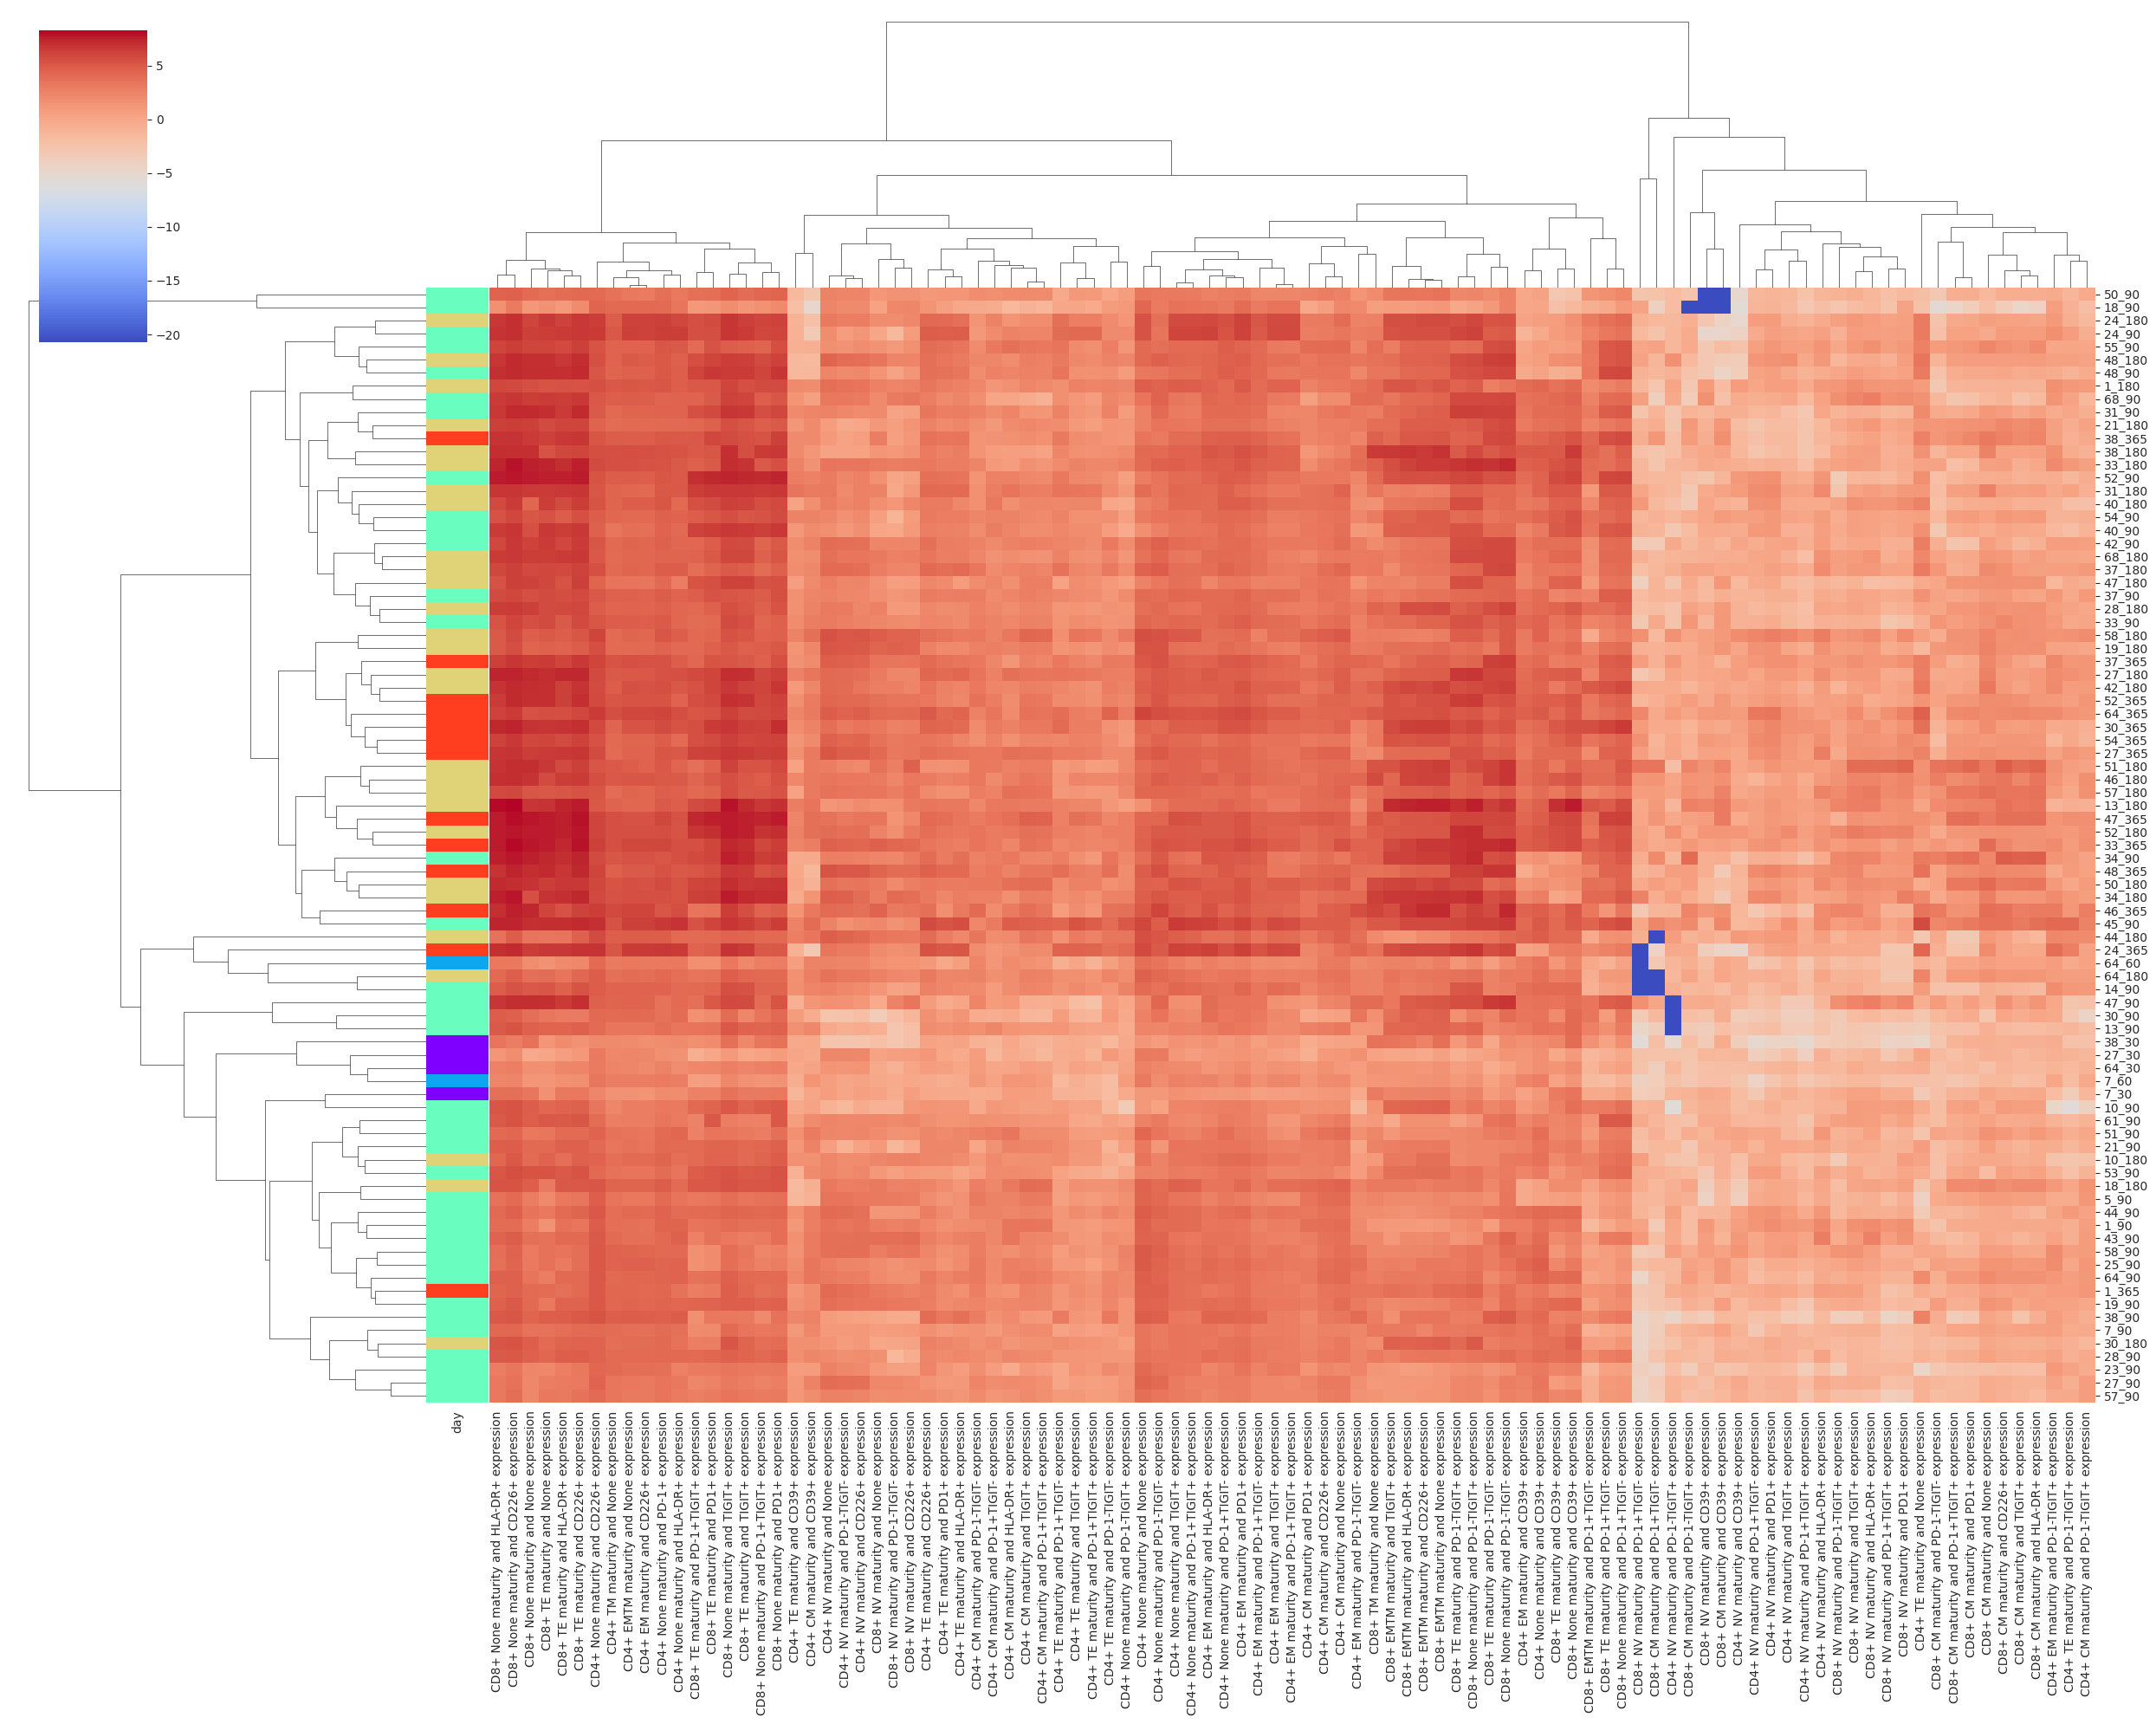

In [50]:
br.plotting.clustermap_wp(
    ds=np.log(df_wo_gvhd.drop(columns=['patient', 'day', 'GVHD_status', 'GVHD_day']) + 0.000000001),  
    figsize=(25,20), xl=True,
    cmap='coolwarm',
    row_colors=df_wo_gvhd['day'].map(
        br.plotting.lin_colors(df_wo_gvhd['day'])
    )
)